In [5]:
ROOT_RESULTS_2 = "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/FINAL" \
                 "/results3/"
DATASET = "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/data/big" \
          "/weapons/weapon_detection/train/augmented_2"
DATASET_TEST = "C:/Users/mupaj/Documents/Apps/cv_weapon_detection/FINAL" \
           "/test_model/"

import math

num_epochs = 100

Found 9394 images belonging to 2 classes.
Found 2348 images belonging to 2 classes.
74/74 [==============================] - 10s 134ms/step
Epoch 2/2
74/74 [==============================] - 10s 134ms/step
Epoch 3/3
74/74 [==============================] - 10s 132ms/step
Epoch 4/4
74/74 [==============================] - 10s 133ms/step
Epoch 5/5
74/74 [==============================] - 10s 135ms/step
Epoch 6/6
74/74 [==============================] - 10s 134ms/step
Epoch 7/7
74/74 [==============================] - 10s 140ms/step
Epoch 8/8
74/74 [==============================] - 10s 137ms/step
Epoch 9/9
74/74 [==============================] - 11s 142ms/step
Epoch 10/10
74/74 [==============================] - 11s 143ms/step
Epoch 11/11
74/74 [==============================] - 10s 141ms/step
Epoch 12/12
74/74 [==============================] - 10s 137ms/step
Epoch 13/13
74/74 [==============================] - 12s 159ms/step
Epoch 14/14
74/74 [==============================] - 10s 136

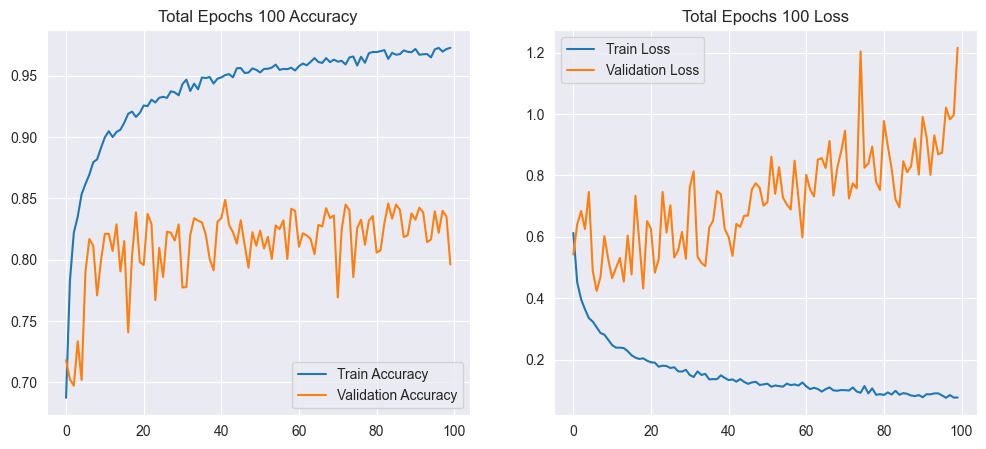

C:\Users\mupaj\Documents\Apps\cv_weapon_detection\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix
import time
import csv
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Assuming you have these two functions somewhere in your code
# def save_matrix_to_csv(matrix, epoch): ...
# def plot_combined_confusion_matrices_from_csv(class_names): ...
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.reset_default_graph()

train_accs, val_accs, train_losses, val_losses = [], [], [], []
all_confusion_matrices = []

# F1 Metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val
def train_model(dataset_dir):

    # ImageDataGenerator for data augmentation, rescaling, and split
    datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        subset='training',
        seed=42
    )

    validation_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        subset='validation',
        seed=42
    )

    # Model creation
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Change here

    # Compile the model with binary_crossentropy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

    # CSV for results
    with open(f"{ROOT_RESULTS_2}results.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Accuracy", "Loss", "F1 Score", "Validation Accuracy", "Validation Loss", "Validation F1 Score", "Time (seconds)"])

        # Initialize a combined confusion matrix with zeros
        combined_conf_matrix = np.zeros((len(train_generator.class_indices), len(train_generator.class_indices)))

        # Training and data collection for 5 epochs
        for epoch in range(1, num_epochs+1):
            start_time = time.time()
            history = model.fit(train_generator, validation_data=validation_generator, epochs=epoch, initial_epoch=epoch-1, batch_size=32, verbose=1)
            end_time = time.time()

            train_accs.append(history.history['accuracy'][-1])
            val_accs.append(history.history['val_accuracy'][-1])
            train_losses.append(history.history['loss'][-1])
            val_losses.append(history.history['val_loss'][-1])

            # Saving epoch data to CSV including F1 score
            writer.writerow([epoch,
                             history.history['accuracy'][-1],
                             history.history['loss'][-1],
                             history.history['f1_score'][-1],
                             history.history['val_accuracy'][-1],
                             history.history['val_loss'][-1],
                             history.history['val_f1_score'][-1],
                             end_time - start_time])

            # Reset validation generator and predict
            validation_generator.reset()
            predictions = model.predict(validation_generator)
            y_pred = np.argmax(predictions, axis=1)
            y_true = validation_generator.classes

            # Compute the confusion matrix
            conf_matrix = confusion_matrix(y_true, y_pred)
            combined_conf_matrix += conf_matrix

    # PLOTTING ACCURACY AND LOSS
    # Plotting accuracy and loss after all epochs
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.legend()
    plt.title(f"Total Epochs {epoch} Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title(f"Total Epochs {epoch} Loss")

    plt.savefig(f"{ROOT_RESULTS_2}total_epochs_plot.png")
    plt.show()

    # Save the final model
    model.save(f'{ROOT_RESULTS_2}model_resuilts_test.h5')

    return train_generator, validation_generator, model

# Usage (Make sure ROOT_RESULTS_2 is defined)

train_generator, validation_generator, model = train_model(DATASET)


